# Solución de la ecuación de una cuerda vibrando


Se presenta la solución de la ecuación de onda usando el método de diferencias finitas.

## Problema

Se quiere resolver la ecuación

$$\frac{\partial^2 u(x, y)}{\partial x^2} = \frac{1}{c^2} \frac{\partial^2 u(x, t)}{\partial t^2} + f(x, t)\, ,$$

para $x\in [0, L]$, con

\begin{align}
&u(x, 0) = g(x)\\
&\frac{\partial u(x, 0)}{\partial t} = h(x)\\
&u(0, t) = u(L, t) = 0\, .
\end{align}

## Esquema de solución

Para resolver el problema usamos un método de diferencias finitas centradas en el espacio
y diferencias finitas hacia adelante en el tiempo. Por tanto, tenemos la siguiente
ecuación para la solución en el nodo $i$ en el instante $n+1$

$$u_i^{n+1} = 2 u_i^{n} - u_i^{n - 1} + \alpha^2[u_{i + 1}^n - 2u_{i}^n + u_{i - 1}^n] + \Delta t^2 f_i^n\, ,$$

para el primer instante usamos

$$u_i^{1} = u_i^{0} - \Delta t\, v_i^{0} + \frac{1}{2}\alpha^2[u_{i + 1}^n - 2u_{i}^n + u_{i - 1}^n] + \Delta t^2 f_i^n\, ,$$

donde $v = {\partial u}/{\partial t}$.


### Deducción de la fórmula para la primera iteración


Si utilizamos el mismo esquema de discretización para la primera iteración obtendríamos

$$u_i^{1} = 2 u_i^{0} - u_i^{-1} + \alpha^2[u_{i + 1}^0 - 2u_{i}^0 + u_{i - 1}^0] + \Delta t^2 f_i^0\, ,$$

sin embargo, no conocemos el valor $u_i^{-1}$. Para encontrar este valor podemos hacer una
expansión de la velocidad, por ejemplo, usando un esquema centrado en $t=0$,

$$v_i^0 = \frac{u_i^1 - u_i^{-1}}{\Delta t}\, ,$$


o

$$u_i^{-1} = u_i^1 - 2\Delta t v_i^{0}\, ,$$

resultando en

$$u_i^{1} = u_i^{0} + \Delta t\, v_i^{0} + \frac{\alpha^2}{2}[u_{i + 1}^0 - 2u_{i}^0 + u_{i - 1}^0] + \Delta t^2 f_i^0\, .$$


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [3]:
%matplotlib notebook
plt.rcParams["mathtext.fontset"] = "cm"

In [4]:
def sol_onda(desp_inicial, vel_inicial, carga, vel_onda=1.0, npuntos=100,
             niteraciones=200, longitud=1.0, cfl=0.5):
    x = np.linspace(0, longitud, npuntos)
    dx = x[1] - x[0]
    dt = cfl * dx/vel_onda
    t = np.linspace(0, dt*niteraciones, niteraciones)
    alpha = vel_onda * dt/dx
    
    #%% Solucion
    solucion = np.zeros((niteraciones, npuntos))

    # Condiciones iniciales
    solucion[0, :] = desp_inicial(x)
    solucion[1, :] = solucion[0, :] + dt * vel_inicial(x) + 0.5*dt**2*carga(x, 0)

    # Solucion para cada tiempo mayor a 2 * dt
    # Note que sólo se actualizan los puntos interiores,
    # pero nunca los puntos extremos.
    for cont_t in range(2, niteraciones):
        q = carga(x, cont_t * dt)
        solucion[cont_t, 1:-1] = alpha**2 * (solucion[cont_t - 1, 2:] +
                    solucion[cont_t - 1, 0:-2] - 2*solucion[cont_t - 1, 1:-1])\
                  + 2*solucion[cont_t - 1, 1:-1] - solucion[cont_t - 2, 1:-1]\
                  + dt**2 * q[1:-1]

    return x, t, solucion


In [5]:
# Condiciones iniciales
def desp_inicial(x):
    """Desplazamiento inicial de la cuerda"""
    return np.zeros_like(x)


def vel_inicial(x):
    """Velocidad inicial de la cuerda"""
    return np.zeros_like(x)

# Carga
def carga(x, t):
    return 15.0 * np.ones_like(x)*t


# Parametros de entrada para una cuerda de guitarra de acero
densidad = 7800 # kg/m^3
diametro = 0.66e-3  # m
area = (np.pi/4) * diametro**2 # m^2
tension = 81.732 # N
vel_onda = np.sqrt(tension/(densidad * area))
npuntos = 20
longitud = 0.6
cfl = 0.5
niteraciones = 100

In [6]:
x, t, solucion = sol_onda(desp_inicial, vel_inicial, carga, vel_onda=vel_onda, longitud=longitud,
                      cfl=1.0)

In [7]:
# Actualizar animacion
def update(data, line):
    line.set_ydata(data)
    return line,

<IPython.core.display.Javascript object>


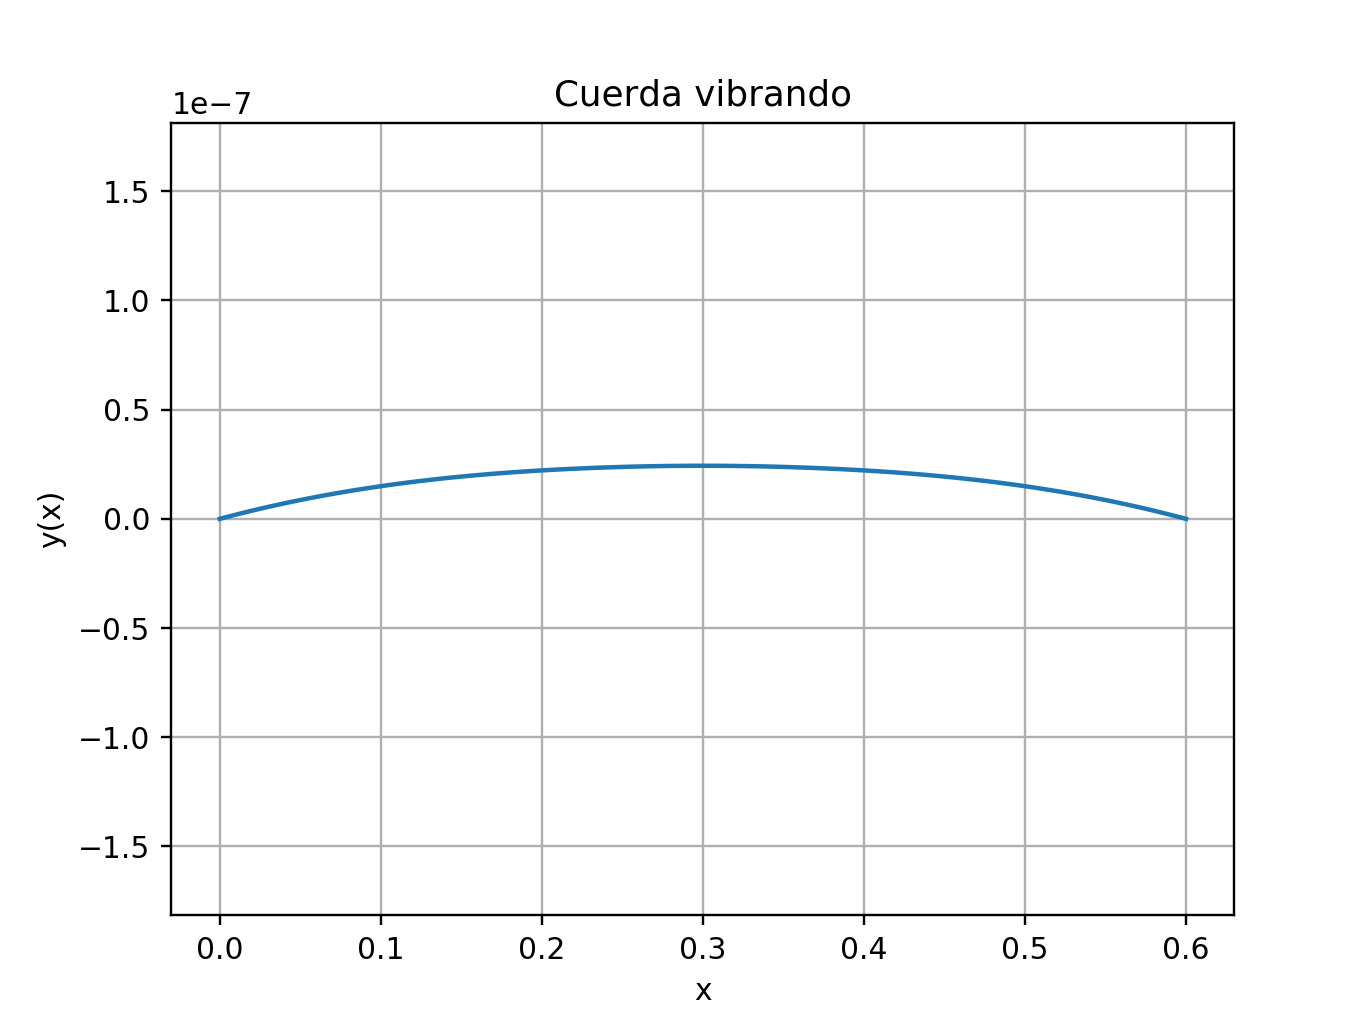

In [8]:
#%% Animacion

max_val = max(np.max(solucion), -np.min(solucion))
fig0, ax0 = plt.subplots()
line0, = ax0.plot(x, solucion[0, :])
ani = animation.FuncAnimation(fig0, update, solucion, interval=niteraciones,
                              repeat=True, fargs=(line0,))
plt.grid()
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Cuerda vibrando')
ax0.set_ylim(-1.2*max_val, 1.2*max_val)
plt.show()


## Soluciones manufacturadas

Para usar el método de soluciones manufacturada se recomienda el uso de CAS
(del inglés *Computer Algebra System*). En este caso usaremos SymPy.

In [9]:
import sympy as sym

In [10]:
sym.init_printing()

In [22]:
xi, tau = sym.symbols("xi tau")
L, v = sym.symbols("L v")

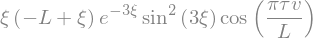

In [24]:
u_manu = xi* sym.exp(-3*xi)*(xi - L)*sym.sin(3*xi)**2*sym.cos(sym.pi*v/L*tau)
u_manu

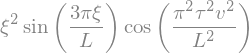

In [12]:
#u_manu = sym.sin(3*sym.pi*xi/L)*xi**2*sym.cos((sym.pi*v/L*tau)**2)
#u_manu

Grafiquemos la solución propuesta para $\tau=0$.

<IPython.core.display.Javascript object>


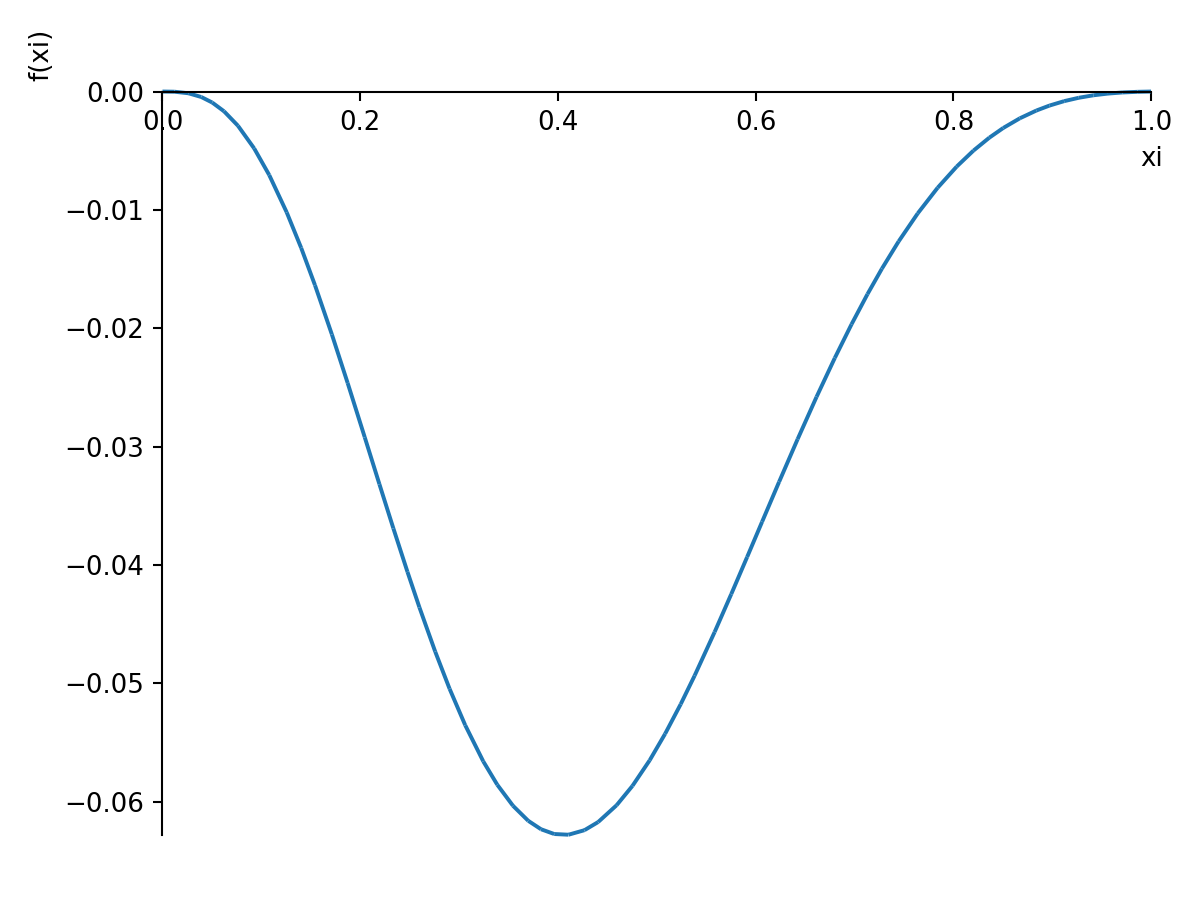

In [25]:
sym.plot(u_manu.subs({L:1, tau: 0}), (xi, 0, 1));

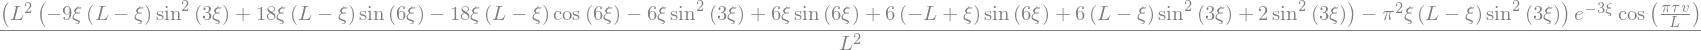

In [26]:
carga_manu = sym.simplify(sym.diff(u_manu, xi, 2) - sym.diff(u_manu, tau, 2)/v**2)
carga_manu

In [27]:
u_manu_fun = sym.lambdify((xi, tau), u_manu.subs({L: 1.0, v: 1.0}), "numpy")
carga = sym.lambdify((xi, tau), carga_manu.subs({v: 1.0, L: 1.0}), "numpy")
u_inicial = sym.lambdify((xi), u_manu.subs({v: 1.0, L: 1.0, tau: 0}), "numpy")
v_inicial = sym.lambdify((xi), 0*xi + u_manu.diff(tau).subs({v: 1.0, L: 1.0, tau:0}), "numpy")

In [28]:
x, t, solucion = sol_onda(u_inicial, v_inicial, carga, vel_onda=1.0)

<IPython.core.display.Javascript object>


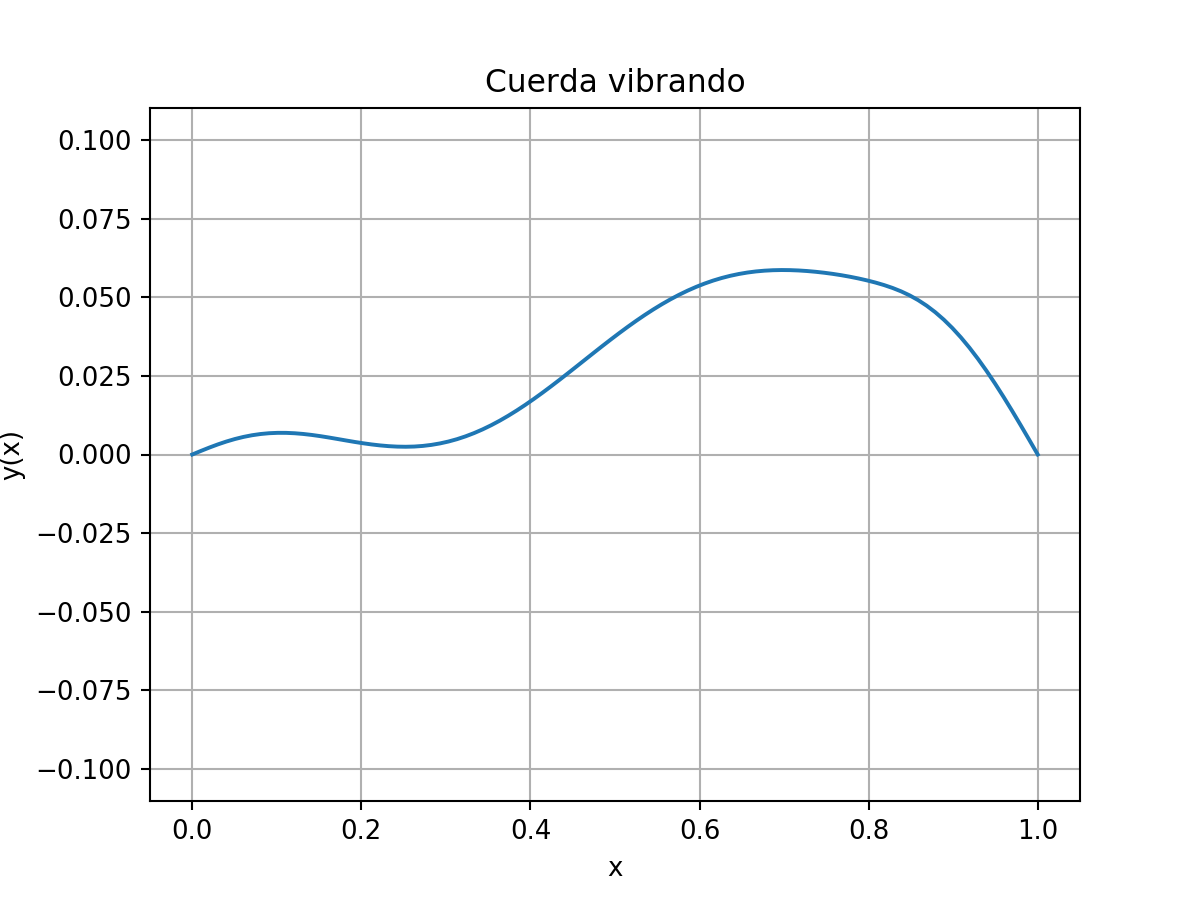

In [29]:
#%% Animacion
max_val = max(np.max(solucion), -np.min(solucion))
fig1, ax1 = plt.subplots()
line1, = ax1.plot(x, solucion[0, :])

ani1 = animation.FuncAnimation(fig1, update, solucion, interval=niteraciones,
                              repeat=True, fargs=(line1,))
plt.grid()
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Cuerda vibrando')
ax1.set_ylim(-1.2*max_val, 1.2*max_val)
plt.show()

In [35]:
log_error = []
for cont in [10, 500, 1000, 5000, 10000]:
    x, t, solucion = sol_onda(u_inicial, v_inicial, carga, vel_onda=1.0, npuntos=cont)
    X, T = np.meshgrid(x, t)
    solucion_manu = u_manu_fun(X, T)
    error_fun = solucion - solucion_manu
    error_abs = np.linalg.norm(error_fun)
    log_error.append(np.log10(error_abs))

<IPython.core.display.Javascript object>


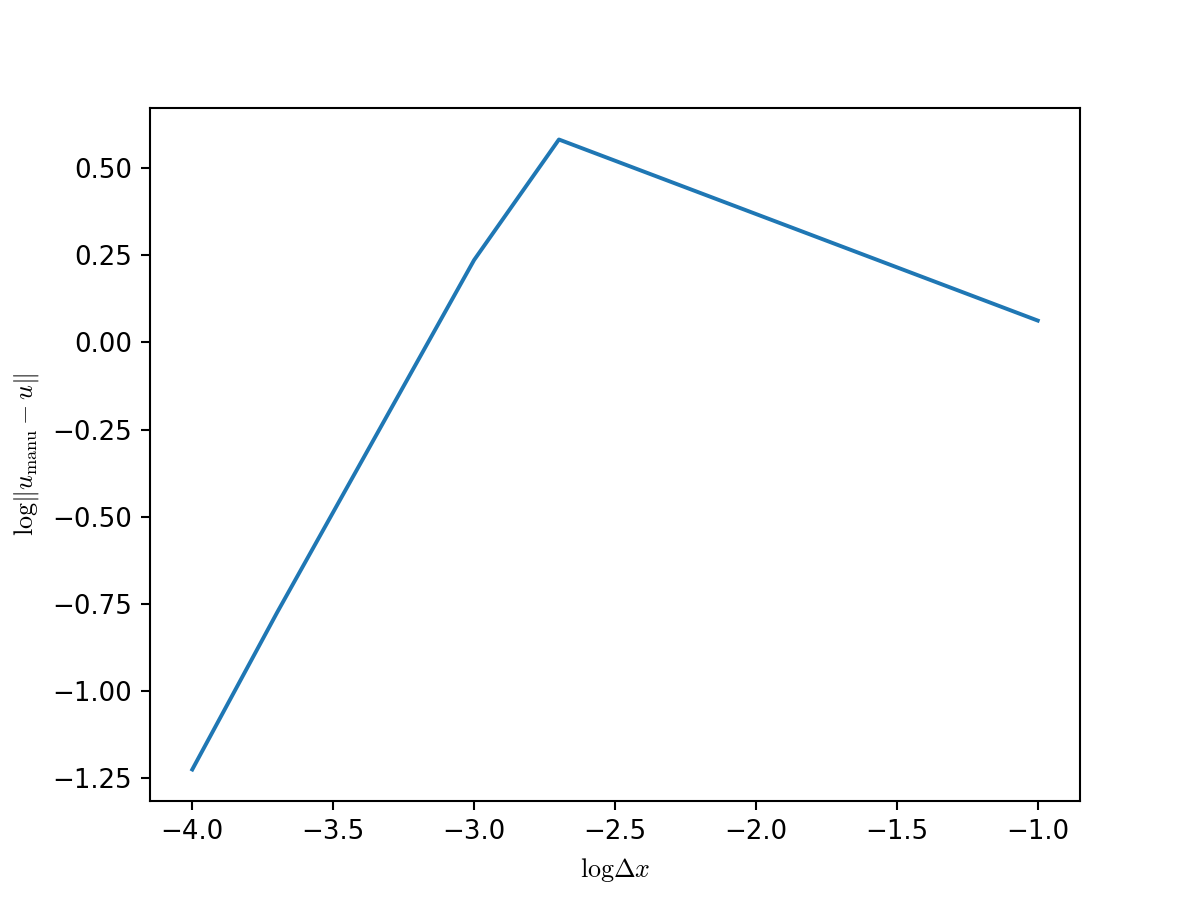

In [36]:
plt.figure()
log_dx = np.log10(1/np.array([10, 500, 1000, 5000, 10000]))
plt.plot(log_dx, log_error)
plt.xlabel(r"$\log\Delta x$")
plt.ylabel(r"$\log\Vert u_\mathrm{manu} - u\Vert$");